# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

# Statistical imports
from scipy.stats import pointbiserialr
from scipy.stats.contingency import association
import statsmodels.api as sm

# import train_test_split function
from sklearn.model_selection import train_test_split

---
## 2. Load data

In [2]:
df = pd.read_csv('./data-clean-after-eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


Now, to enable us to run the new example features, lets import the price data

In [4]:
price_df = pd.read_csv('data-price.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [5]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  193002 non-null  object        
 1   price_date          193002 non-null  datetime64[ns]
 2   price_off_peak_var  193002 non-null  float64       
 3   price_peak_var      193002 non-null  float64       
 4   price_mid_peak_var  193002 non-null  float64       
 5   price_off_peak_fix  193002 non-null  float64       
 6   price_peak_fix      193002 non-null  float64       
 7   price_mid_peak_fix  193002 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 11.8+ MB


---

## 3. Feature engineering



### Split Data into Training and Test Data

Before going too much further with feature enginnering, in order to avoid overfitting, it may help to split our data into training and test data.

In [6]:
# Drop the target column from client_prices
clients = df.copy()

X = clients.drop(columns = "churn")

# Save the target column as a series.
y = clients['churn']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

We'll also add the X and Y trainng data together to make querying easier.

In [7]:
train = X_train.copy()
train['churn'] = y_train

To make identifying churn easier, we'll label 1 as yes and 0 as no in a separate column. 

In [8]:
# Assign new column with yes/no values based on churn: 1 => 'yes', and 0 => 'no'
train.loc[(train['churn'] == 1), 'churn_char'] = 'yes'
train.loc[(train['churn'] == 0), 'churn_char'] = 'no'


### Difference between off-peak prices in December and preceding January

The code below was created by a colleague to calculate the feature described above. We'll use this as an example to create features with predictive power.


In [9]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


Based on our colleagues feature, let's create a difference column for each price feature. 

In [10]:
# Function to create 
def price_diff_dec(column_list):   
    
    # Create New DataFrame
    price_diff = pd.DataFrame(price_df.id.unique()).rename(columns = {0: 'id'})
    
    for column in column_list:
         
        # new column name
        new_column = 'diff_jan_dec_' + column
        
        # Get january and december prices
        jan_prices = price_df.groupby('id').first().reset_index()
        dec_prices = price_df.groupby('id').last().reset_index()
    
        # Calculate the difference
        diff = pd.merge(dec_prices.rename(columns={column: 'dec'}), jan_prices.drop(columns='price_date'), on='id')
        diff[new_column] = diff['dec'] - diff[column]
        diff = diff[['id', new_column]]
        
        # Add new column to the training data
        price_diff = pd.merge(price_diff, diff, on = 'id', how = 'inner')

    return price_diff

In [11]:
# List of columns
cols = ['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']

diff_price_jan = price_diff_dec(cols)
diff_price_jan.head()

,id,diff_jan_dec_price_off_peak_var,diff_jan_dec_price_peak_var,diff_jan_dec_price_mid_peak_var,diff_jan_dec_price_off_peak_fix,diff_jan_dec_price_peak_fix,diff_jan_dec_price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,-0.005508,0.000000,0.000000,0.177779,0.000000,0.000000
1,31f2ce549924679a3cbb2d128ae9ea43,-0.007221,-0.002324,0.003560,0.162916,0.097749,0.065166
2,36b6352b4656216bfdb96f01e9a94b4e,-0.010018,-0.005120,0.000763,0.162916,0.097749,0.065166
3,48f3e6e86f7a8656b2c6b6ce2763055e,-0.000488,0.000000,0.000000,0.177779,0.000000,0.000000
4,cce88c7d721430d8bd31f71ae686c91e,-0.039332,-0.033207,-0.028926,-0.335085,-0.400251,-0.432834


### Extract month, day of month, day of year and year into individual columns

The 'date_modif_prod' column tells the date of the last time a client's product was last modified. Since electrical parts wear out with time, this may have a small influence on churn. But it may be easier to see by making separate year and month attributes. So, here we'll make a 'year_modif', 'month_modif', and 'day_of_year_modif' columns. 

In [12]:
# New column in prices: Months for each record
price_df['month'] = pd.DatetimeIndex(price_df['price_date']).month

In [13]:
pd.DataFrame(price_df.groupby(['month'], observed = False)[['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']].mean()).sort_values(by = 'price_peak_fix')

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
month,,,,,,
6,0.143731,0.055255,0.029902,43.347320,10.415769,6.281304
5,0.143534,0.055359,0.030393,43.315388,10.602453,6.390806
9,0.137933,0.053532,0.030606,43.351874,10.602979,6.391788
10,0.137899,0.053713,0.030641,43.354226,10.605431,6.396084
11,0.137909,0.053620,0.030737,43.422764,10.641489,6.421622
7,0.143683,0.055369,0.030636,43.345012,10.642236,6.421464
12,0.138011,0.053957,0.030732,43.504177,10.644109,6.427104
3,0.143104,0.055118,0.030396,43.254033,10.644489,6.430121
4,0.143259,0.056035,0.030492,43.288439,10.647277,6.423156


In [14]:
pd.DataFrame(price_df.groupby(['month'], observed = False)[['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']].mean()).sort_values(by = 'price_off_peak_var')

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
month,,,,,,
10,0.137899,0.053713,0.030641,43.354226,10.605431,6.396084
11,0.137909,0.053620,0.030737,43.422764,10.641489,6.421622
8,0.137933,0.053605,0.030717,43.365366,10.661678,6.431518
9,0.137933,0.053532,0.030606,43.351874,10.602979,6.391788
12,0.138011,0.053957,0.030732,43.504177,10.644109,6.427104
1,0.142568,0.054950,0.030333,43.226643,10.692921,6.455861
2,0.142767,0.055053,0.030367,43.238161,10.673719,6.449016
3,0.143104,0.055118,0.030396,43.254033,10.644489,6.430121
4,0.143259,0.056035,0.030492,43.288439,10.647277,6.423156


Averages don't change much from month to month. Let's check the grouped by customers compared to the original df, to see if any companies are listed more than once for each month. 

Since averages don't seem to change from month to month,  the customers are only listed once for each month

### Combine Datasets

We'll add these difference in prices to the training data. Also, to make comparisons easier, we'll combine the client training data with average price data. In order to do so, we'll run average prices for each customer in the price data, and merge that information with the client data. 

In [15]:
# Make a copy of each dataframe
prices = price_df.copy()

# Drop the dates from price data
prices_avg = prices.drop(columns = 'price_date')

# Group by ids, take the average of each price column, and reset index
prices_avg = pd.DataFrame(price_df.groupby(['id'], observed = False)[['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']].mean()).sort_values(by = 'id')
prices_avg = prices_avg.reset_index()

# Merge the two together, keeping only matching ids
train = pd.merge(train, prices_avg, on = 'id', how = 'inner')



### Check Correlation of Columns with Churn

Let's check if his new feature has any correlation with churn in the training data. Since churn is technically a binary categorical variable, in order to check which numerical variables might have the most influence on churn, we'll run the correlations using the point-biserial correlation coefficient.

In [16]:
# Together data about prices, diffs in prices, and clients
train = pd.merge(train, diff, on = 'id', how = 'inner')
train = pd.merge(train, diff_price_jan, on = 'id', how = 'inner')

In [17]:
# List of numerical columns
col_list = ['churn', 'diff_jan_dec_price_off_peak_var', 'diff_jan_dec_price_peak_var', 'diff_jan_dec_price_mid_peak_var', 'diff_jan_dec_price_off_peak_fix', 'diff_jan_dec_price_peak_fix', 'diff_jan_dec_price_mid_peak_fix', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power', 'cons_12m', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_cons_year', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'num_years_antig', 'pow_max', 'var_year_price_off_peak_var', 'var_year_price_peak_var', 'var_year_price_mid_peak_var', 'var_year_price_off_peak_fix', 'var_year_price_peak_fix', 'var_year_price_mid_peak_fix', 'var_year_price_off_peak', 'var_year_price_peak', 'var_year_price_mid_peak', 'forecast_price_pow_off_peak', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'var_6m_price_off_peak_var', 'var_6m_price_peak_var', 'var_6m_price_mid_peak_var', 'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix', 'var_6m_price_mid_peak_fix', 'var_6m_price_off_peak', 'var_6m_price_peak', 'var_6m_price_mid_peak', 'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']

# Select numerical columns
cp_nums = train[col_list]

In [18]:
# Create a function that takes a dataframe containing churn and outputs the pb_coeffs for all numerical columns and churn
def pb_corr(df):
    # Empty list for corr and p-values
    corr_ch = []
    
    # For each price value, point-biserial correlation coefficient correlation with churn
    for column in df:
        corr, p_val = pointbiserialr(df.churn, df[column])
        corr_ch.append([column, abs(corr), round(p_val, 6)])
    
    # Add the data to a dataframe, sort by coefficient in descending order
    ch_corr_df = pd.DataFrame(corr_ch).rename(columns = {0: 'attribute', 1: 'PB_corr_coeff', 2: 'p_value'}).sort_values(by = 'PB_corr_coeff', ascending = False).reset_index(drop = True)
    return ch_corr_df

In [19]:
# Find point-biserial correlation coeffecients for the numerical columns and churn
pb_corr(cp_nums)

,attribute,PB_corr_coeff,p_value
0,churn,1.000000,0.000000
1,margin_net_pow_ele,0.097129,0.000000
2,margin_gross_pow_ele,0.097072,0.000000
3,num_years_antig,0.076744,0.000000
4,price_peak_fix,0.054900,0.000000
5,price_mid_peak_var,0.054202,0.000000
6,price_mid_peak_fix,0.052592,0.000000
7,net_margin,0.045614,0.000001
8,cons_last_month,0.043831,0.000002
9,forecast_meter_rent_12m,0.043505,0.000003


The gross and net margin for power have the highest correlation with churn. The next is the number of years a client has been with the company. In fourth and fifth place are the following features:
- 'price_peak_fix', which is the price of power for the 2nd period
- 'price_mid_peak_var', the price of energy for the 3rd period

### Create features based on difference between maximum and minimum prices

Using these last two features mentioned, we'll find the difference between each client's December 2015 price and January 2015 price.



en 

In [20]:
# Group prices by client and month for price_peak_fix and price_mid_peak_var
my_month_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_peak_fix': 'mean', 'price_mid_peak_var': 'mean'}).reset_index()

# Get january and december prices
jan2_prices = my_month_price_by_id.groupby('id').first().reset_index().rename(columns = {'price_peak_fix': 'jan_power_2nd', 'price_mid_peak_var': 'jan_energy_3rd' }).drop(columns = 'price_date')
dec2_prices = my_month_price_by_id.groupby('id').last().reset_index().rename(columns = {'price_peak_fix': 'dec_power_2nd', 'price_mid_peak_var': 'dec_energy_3rd'}).drop(columns = 'price_date')

# Calculate the difference
diff2 = pd.merge(dec2_prices, jan2_prices, on='id')
diff2['power_diff_2nd'] = diff2['dec_power_2nd'] - diff2['jan_power_2nd']
diff2['energy_diff_3rd'] = diff2['dec_energy_3rd'] - diff2['jan_energy_3rd']
diff2 = diff2[['id', 'power_diff_2nd','energy_diff_3rd']]
diff2.head()

,id,power_diff_2nd,energy_diff_3rd
0,0002203ffbb812588b632b9e628cc38d,0.097749,0.003487
1,0004351ebdd665e6ee664792efc4fd13,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.097749,0.000763
4,00114d74e963e47177db89bc70108537,0.000000,0.000000


It may also be useful to also find the difference between the max and min price for each customer. We'll do that for the four price columns with the highest point-biserial correlation coefficients.

In [21]:
# Make data frames with the max and min price for each customer for price_peak_fix and price_mid_peak_var
max_price_df = price_df.groupby(['id']).agg({'price_peak_fix': 'max', 'price_mid_peak_var': 'max', 'price_mid_peak_fix': 'max', 'price_peak_var': 'max', 'price_off_peak_var': 'max', 'price_off_peak_fix': 'max'}).reset_index()
min_price_df = price_df.groupby(['id']).agg({'price_peak_fix': 'min', 'price_mid_peak_var': 'min', 'price_mid_peak_fix': 'min', 'price_peak_var': 'min', 'price_off_peak_var': 'min', 'price_off_peak_fix': 'min'}).reset_index()

# Change column names
min_price_df = min_price_df.rename(columns = {'price_peak_fix': 'min_price_power2', 'price_mid_peak_var': 'min_price_energy3', 'price_mid_peak_fix': 'min_price_power3', 'price_peak_var': 'min_price_energy2', 'price_off_peak_var': 'min_price_energy1', 'price_off_peak_fix': 'min_price_power1'})
max_price_df = max_price_df.rename(columns = {'price_peak_fix': 'max_price_power2', 'price_mid_peak_var': 'max_price_energy3', 'price_mid_peak_fix': 'max_price_power3', 'price_peak_var': 'max_price_energy2', 'price_off_peak_var': 'max_price_energy1', 'price_off_peak_fix': 'max_price_power1'})

# Merge the two diff dfs
price_diff = pd.merge(min_price_df, max_price_df, on='id')

# Calculate the differences between max and min prices.
price_diff['mdiff_power1'] = price_diff.max_price_power1 - price_diff.min_price_power1
price_diff['mdiff_power2'] = price_diff.max_price_power2 - price_diff.min_price_power2
price_diff['mdiff_power3'] = price_diff.max_price_power3 - price_diff.min_price_power3
price_diff['mdiff_energy1'] = price_diff.max_price_energy1 - price_diff.min_price_energy1
price_diff['mdiff_energy2'] = price_diff.max_price_energy2 - price_diff.min_price_energy2
price_diff['mdiff_energy3'] = price_diff.max_price_energy3 - price_diff.min_price_energy3

price_diff = price_diff[['id', 'mdiff_power1', 'mdiff_energy1','mdiff_power2', 'mdiff_energy2', 'mdiff_power3', 'mdiff_energy3']]
price_diff.head(5)

,id,mdiff_power1,mdiff_energy1,mdiff_power2,mdiff_energy2,mdiff_power3,mdiff_energy3
0,0002203ffbb812588b632b9e628cc38d,0.162916,0.008161,0.097749,0.004169,0.065166,0.003541
1,0004351ebdd665e6ee664792efc4fd13,0.177779,0.004462,0.000000,0.000000,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,1.500000,0.054905,0.000000,0.000000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.162916,0.010018,0.097752,0.005120,0.065172,0.000817
4,00114d74e963e47177db89bc70108537,0.000001,0.004462,0.000000,0.000000,0.000000,0.000000


In [22]:
# merge this data with the cp_nums and client prices dataframes.
train = pd.merge(train, diff2, on = 'id')
train = pd.merge(train, price_diff, on = 'id')

In [23]:
# List of numerical columns
col_list = ['churn', 'mdiff_power2', 'mdiff_energy2', 'mdiff_power3', 'mdiff_energy3', 'power_diff_2nd', 'energy_diff_3rd', 'diff_jan_dec_price_off_peak_var', 'diff_jan_dec_price_peak_var', 'diff_jan_dec_price_mid_peak_var', 'diff_jan_dec_price_off_peak_fix', 'diff_jan_dec_price_peak_fix', 'diff_jan_dec_price_mid_peak_fix', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power', 'cons_12m', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_cons_year', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'num_years_antig', 'pow_max', 'var_year_price_off_peak_var', 'var_year_price_peak_var', 'var_year_price_mid_peak_var', 'var_year_price_off_peak_fix', 'var_year_price_peak_fix', 'var_year_price_mid_peak_fix', 'var_year_price_off_peak', 'var_year_price_peak', 'var_year_price_mid_peak', 'forecast_price_pow_off_peak', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'var_6m_price_off_peak_var', 'var_6m_price_peak_var', 'var_6m_price_mid_peak_var', 'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix', 'var_6m_price_mid_peak_fix', 'var_6m_price_off_peak', 'var_6m_price_peak', 'var_6m_price_mid_peak', 'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']

# Select numerical columns
cp_nums = train[col_list]

# Find point-biserial correlation coeffecients for the numerical columns and churn
pb_corr(cp_nums)

,attribute,PB_corr_coeff,p_value
0,churn,1.000000,0.000000
1,margin_net_pow_ele,0.097129,0.000000
2,margin_gross_pow_ele,0.097072,0.000000
3,num_years_antig,0.076744,0.000000
4,price_peak_fix,0.054900,0.000000
5,price_mid_peak_var,0.054202,0.000000
6,price_mid_peak_fix,0.052592,0.000000
7,net_margin,0.045614,0.000001
8,cons_last_month,0.043831,0.000002
9,forecast_meter_rent_12m,0.043505,0.000003


Running differences this way actually seems to decrease the point-biserial correlation coefficient for some features, but the p-value for the attibutes that are lower on the list is higher, so it may not be reliable for those columns.

### Churn Proportions in Quartiles

While the numerical columns have different measures, it could be useful to see the counts or percentages of customers who churned in each quartile. We'll calculate the pertentages of clients who churned in each quartile fore each numerical attribute. For example, for clients who had the lowest 25% of prices, what was the churn rate? But technically, they won't always be exact quartiles, since the numerical attributes have differing distributions. We'll use the following 4 labels for the 4 quartiles:
- Very Low
- Low
- Moderate
- High

A new column will tell the cut (quartile) that each customer's numerical value falls in. We'll then use those cuts for defining our function for proportions. Later on, we'll move on to differences between percentile rankings.

In [24]:
def calc_proportions(df, column, Q1, Q2, Q3):
    
    # Calculate quartiles for the column for making cut
    my_groups = df[column].quantile([0.00, Q1, Q2, Q3, 1.00])

    # labels for the groups
    labels = ['Very Low','Low','Moderate','High']

    # bins for the cuts
    bins = [-1, my_groups[Q1], my_groups[Q2], my_groups[Q3], my_groups[1.00]]

    cut = 'cut_' + column

    # Assign the labels to a new column in df, our copy of the training features
    df[cut] = pd.cut(df[column], bins=bins, labels=labels)

    # Dataframe for churn values
    pr_churn = pd.DataFrame(df.churn_char.unique()).sort_values(by = 0).reset_index(drop = True)

    pr_churn = pr_churn.rename(columns = {0: "churn"})

    # How many from each price_cut group is in each churn category
    churn_mult = pd.DataFrame(df.groupby([cut, 'churn'], observed = False)['churn'].count())

    # Assign the grouped values to pr_churn dataframe
    pr_churn[labels[0]] = [churn_mult.xs(labels[0]).loc[0].values.max(), churn_mult.xs(labels[0]).loc[1].values.max()]
    pr_churn[labels[1]] = [churn_mult.xs(labels[1]).loc[0].values.max(), churn_mult.xs(labels[1]).loc[1].values.max()]
    pr_churn[labels[2]] = [churn_mult.xs(labels[2]).loc[0].values.max(), churn_mult.xs(labels[2]).loc[1].values.max()]
    pr_churn[labels[3]] = [churn_mult.xs(labels[3]).loc[0].values.max(), churn_mult.xs(labels[3]).loc[1].values.max()]
    
    # Total for each price_cut, so that percentages can be calculated
    total = pr_churn[labels[0]] + pr_churn[labels[1]] + pr_churn[labels[2]] + pr_churn[labels[3]]

    # Calculate percentages for each 
    ch_prop = pr_churn[pr_churn.columns[1:]].div(total, 0)*100

    # Add the churn column
    ch_prop['churn'] = pr_churn['churn']

    # Re-order the columns
    ch_prop = ch_prop[['churn', 'Very Low', 'Low', 'Moderate', 'High']]
    
    return ch_prop

In [25]:
calc_proportions(train, 'margin_net_pow_ele', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,25.884579,25.808893,24.938505,23.368023
1,yes,16.696589,18.761221,25.942549,38.599641


In [26]:
calc_proportions(train, 'price_peak_fix', 0.30, 0.72, 0.89)

,churn,Very Low,Low,Moderate,High
0,no,62.175970,10.927152,16.508988,10.387890
1,yes,53.231598,13.824057,18.761221,14.183124


In [27]:
calc_proportions(train, 'price_peak_var', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,44.210028,6.272469,25.175024,24.342479
1,yes,39.407540,6.104129,23.249551,31.238779


In [28]:
nya = calc_proportions(train, 'num_years_antig', 0.25, 0.50, 0.75)
nya

,churn,Very Low,Low,Moderate,High
0,no,42.346263,16.177862,33.727531,7.748344
1,yes,57.360862,13.913824,23.518851,5.206463


In [29]:
calc_proportions(train, 'var_year_price_peak_var', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,44.210028,6.622517,24.947966,24.219489
1,yes,39.407540,3.949731,25.763016,30.879713


In [30]:
# Calculate the proportions in each quartile for the energy price during the 1st period
calc_proportions(train, 'var_year_price_off_peak_var', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,25.487228,25.279092,24.777673,24.456008
1,yes,20.466786,22.262118,27.109515,30.161580


In [31]:
calc_proportions(train, 'mdiff_energy3', 0.30, 0.72, 0.89)

,churn,Very Low,Low,Moderate,High
0,no,62.611164,10.066225,16.773888,10.548723
1,yes,53.321364,12.208259,19.479354,14.991023


In [32]:
calc_proportions(train, 'price_off_peak_fix', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,26.017029,23.59508,25.979186,24.408704
1,yes,29.174147,25.40395,19.748654,25.673250


In [33]:
calc_proportions(train, 'offpeak_diff_dec_january_energy', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,25.269631,24.228950,25.402081,25.099338
1,yes,28.276481,26.660682,22.621185,22.441652


In [34]:
calc_proportions(train, 'forecast_cons_12m', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,25.023652,25.175024,25.061495,24.739830
1,yes,24.775583,23.339318,24.416517,27.468582


In [35]:
calc_proportions(train, 'price_off_peak_var', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,24.768212,24.635762,25.392621,25.203406
1,yes,27.468582,28.815081,20.736086,22.980251


In [36]:
calc_proportions(train, 'energy_diff_3rd', 0.30, 0.72, 0.89)

,churn,Very Low,Low,Moderate,High
0,no,70.870388,1.589404,19.176916,8.363292
1,yes,64.991023,2.692998,23.070018,9.245961


In [37]:
calc_proportions(train, 'offpeak_diff_dec_january_energy', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,25.269631,24.228950,25.402081,25.099338
1,yes,28.276481,26.660682,22.621185,22.441652


In [38]:
calc_proportions(train, 'offpeak_diff_dec_january_power', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,27.060949,23.276600,37.016259,12.646192
1,yes,28.364950,26.829268,30.352304,14.453478


In [39]:
calc_proportions(train, 'diff_jan_dec_price_peak_var', 0.2, 0.4, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,19.829707,19.422895,48.760643,11.986755
1,yes,24.865350,22.351885,42.728905,10.053860


In [40]:
calc_proportions(train, 'diff_jan_dec_price_mid_peak_fix', 0.05, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,4.670408,67.716161,23.761058,3.852373
1,yes,6.515837,60.904977,27.963801,4.615385


In [41]:
calc_proportions(train, 'cons_last_month', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,34.427625,15.458846,25.080416,25.033113
1,yes,32.944345,18.222621,24.236984,24.596050


In [42]:
# Calculate the proportions in each quartile for the power price during the 1st period.
calc_proportions(train, 'var_year_price_off_peak_fix', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,25.600757,25.685904,24.806055,23.907285
1,yes,26.391382,25.493716,22.980251,25.134650


In [43]:
# FORECASTED ENERGY PRICE 1ST PERIOD
# Calculate the proportions for forcasted energy price for the 1st period.
calc_proportions(train, 'forecast_price_energy_off_peak', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,25.042573,24.701987,26.177862,24.077578
1,yes,29.263914,26.929982,21.095153,22.710952


In [44]:
# FORECASTED ENERGY PRICE 2ND PERIOD
# Calculate the proportions for forcasted energy price for the 2nd period.
calc_proportions(train, 'forecast_price_energy_peak', 0.38, 0.60, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,48.666036,12.450331,14.872280,24.011353
1,yes,43.357271,8.976661,17.235189,30.430880


In [45]:
# POWER PRICE 2ND PERIOD
# Calculate the proportions for power price for the 2nd period.
calc_proportions(train, 'var_year_price_peak_fix', 0.25, 0.68, 0.88)

,churn,Very Low,Low,Moderate,High
0,no,67.246925,3.812677,17.663198,11.277200
1,yes,59.694794,5.565530,19.569120,15.170557


In [46]:
# POWER PRICE 1ST PERIOD
# Calculate the proportions for forcasted Power price for the 1st period.
calc_proportions(train, 'forecast_price_pow_off_peak', 0.25, 0.37, 0.88)

,churn,Very Low,Low,Moderate,High
0,no,31.967833,4.787133,51.778619,11.466414
1,yes,38.061041,6.283662,42.908438,12.746858


In [47]:
# electricity consumption in the last 12 months
calc_proportions(train, 'cons_12m', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,25.127720,25.052034,24.938505,24.881741
1,yes,23.877917,24.416517,25.583483,26.122083


In [48]:
# Gas consumption in the last 12 months
calc_proportions(train, 'cons_gas_12m', 0.30, 0.83, 0.95)

,churn,Very Low,Low,Moderate,High
0,no,82.109745,0.586566,12.081362,5.222327
1,yes,85.098743,0.718133,11.220826,2.962298


In [49]:
calc_proportions(train, 'pow_max', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,25.837275,30.416272,19.356670,24.389782
1,yes,23.429084,26.032316,19.748654,30.789946


In [50]:
calc_proportions(train, 'imp_cons', 0.25, 0.50, 0.75)

,churn,Very Low,Low,Moderate,High
0,no,42.620624,7.483444,24.872280,25.023652
1,yes,40.394973,8.617594,26.211849,24.775583


In [51]:
calc_proportions(train, 'nb_prod_act', 0.50, 0.88, 0.98)

,churn,Very Low,Low,Moderate,High
0,no,78.315989,16.736045,3.500473,1.447493
1,yes,81.238779,14.003591,3.590664,1.166966


By inspecting the high and very low categories, the difference in proportions between those who churned, and those who didn't churn was as high as 5 to 15 percent for the first eight calculated proportions tables above. The other attributes that follow have smaller differences in percentages. The eight features with the greater differences in percentages include:

- Net margin for power
- How long the client has been with PowerCo
- A client's average price of power for the 1st period.
- A client's average price of power for the 2nd period.
- A client's average price of energy for the 2nd period.
- The yearly price of energy for the 2nd period.
- The yearly price of energy for the 1st period.
- The difference between a clients maximum and minimum energy price for the 3rd period. (This is a new feature we calcuated)

### Categorical Features

We'll group the data by each catagorical attribute and by churn to see the counts and percentages in each category. 

In [52]:
# Function to calculate the counts and percentages.
def cat_props(df, feature, target):
    grouped = df.groupby([feature, target], observed = False)['id'].count().unstack(level=1)
    group_perc = (grouped.div(grouped.sum(axis=1), axis=0)*100)
    group_perc['count_no'] = grouped['no']
    group_perc['count_yes'] = grouped['yes']
    return group_perc

In [53]:
cat_props(train, 'origin_up', 'churn_char')

churn_char,no,yes,count_no,count_yes
origin_up,,,,
MISSING,96.226415,3.773585,51.0,2.0
ewxeelcelemmiwuafmddpobolfuxioce,100.000000,NaN,1.0,NaN
kamkkxfxxuwbdslkwifmmcsiusiuosws,94.439592,5.560408,3244.0,191.0
ldkssxwpmemidmecebumciepifcamkci,91.897233,8.102767,2325.0,205.0
lxidpiddsbxsbosboudacockeimpuepw,87.356525,12.643475,4947.0,716.0
usapbepcfoloekilkwsdiboslwaxobdp,100.000000,NaN,2.0,NaN


In [54]:
cat_props(train, 'channel_sales', 'churn_char')

churn_char,no,yes,count_no,count_yes
channel_sales,,,,
MISSING,92.792186,7.207814,2755.0,214.0
epumfxlbckeskwekxbiuasklxalciiuu,100.000000,NaN,3.0,NaN
ewpakwlliwisiwduibdlfmalxowmwpci,92.244898,7.755102,678.0,57.0
fixdbufsefwooaasfcxdxadsiekoceaa,100.000000,NaN,1.0,NaN
foosdfpfkusacimwkcsosbicdxkicaua,87.952030,12.047970,4767.0,653.0
lmkebamcaaclubfxadlmueccxoimlema,94.391245,5.608755,1380.0,82.0
sddiedcslfslkckwlfkdpoeeailfpeds,100.000000,NaN,10.0,NaN
usilxuppasemubllopkaafesmlibmsdf,90.036900,9.963100,976.0,108.0


In [55]:
cat_props(train, 'has_gas', 'churn_char')

churn_char,no,yes,count_no,count_yes
has_gas,,,,
f,90.056227,9.943773,8649,955
t,92.355769,7.644231,1921,159


Sales channel seems to make the most difference, since there are five sales channels that have over 600 clients. The percentage of those who churned in each of those categories ranges from 5.6% to 12%.

### Difference in Price

What if we could see which clients moved price category from one period to another, and whether that influenced churn. For example, if a client went from "Very Low" in the first period to "Low" or "Moderate" in the 2nd period, that would be considered being moved to a higher price catergory. 

Remember, the price categories are based on percentiles of prices in that period. In other words, the category is a client's price in relation to what prices other clients have. So, if we say the client's price category went up, it doensn't necessarily mean their price went up. It could just mean that the prices of other clients went down more than theirs did.

To store the difference in price category from the 1st period to the 2nd period, we'll create a new column for each set of columns, which tells whether the client's price category moved higher, lower, or stayed the same between two specified price periods. Then we'll graph the proportions for churn for that shift column.

In [56]:
# Create function that creates a new column that holds the change/shift values. Then use that column to calculate porportions for churn.
def calc_diff_proportions(df, col_after, col_before):

    # string variables for column names
    shift = 'shift_' + col_after
    col_after = 'cut_' + col_after
    col_before = 'cut_' + col_before
    
    # Create new column (shift) for holding the shift values
    df.loc[((df[col_after] > df[col_before])), shift] = 'higher' # type: ignore
    df.loc[((df[col_after] < df[col_before])), shift] = 'lower'
    df.loc[((df[col_after] == df[col_before])), shift] = 'same'

    # Multi-dimensional dataframe with counts grouped by shift and churn
    diff_mult = pd.DataFrame(df.groupby([shift, 'churn'], observed = False)['churn'].count())

    # Dataframe for churn values rearranged
    pr_churn = pd.DataFrame(df.churn_char.unique()).sort_values(by = 0).reset_index(drop = True)

    pr_churn = pr_churn.rename(columns = {0: "churn"})

    # Assign the grouped values to pr_churn dataframe
    pr_churn['higher'] = [diff_mult.xs('higher').loc[0].values.max(), diff_mult.xs('higher').loc[1].values.max()]
    pr_churn['lower'] = [diff_mult.xs('lower').loc[0].values.max(), diff_mult.xs('lower').loc[1].values.max()]
    pr_churn['same'] = [diff_mult.xs('same').loc[0].values.max(), diff_mult.xs('same').loc[1].values.max()]

    # Total for each price_cut, so that percentages can be calculated
    total = pr_churn['higher'] + pr_churn['lower'] + pr_churn['same']

    # Calculate percentages for each 
    ch_prop = pr_churn[pr_churn.columns[1:]].div(total, 0)*100

    # Add the churn column
    ch_prop['churn'] = pr_churn['churn']

    # Re-order the columns
    ch_prop = ch_prop[['churn', 'higher', 'same', 'lower']]
    
    return ch_prop

# Define a function for showing the shift in price category for clients from one period to another
def plot_diff_proportions(df, col_after, col_before, horiz, font):

    # Select the size of the graphs
    plt.rcParams['figure.figsize'] = 12, 5

    prop = calc_diff_proportions(df, col_after, col_before)
    
    # Plot the higher feature using a Horizontal Percentage Stacked Bar Chart
    prop.plot(
        x = 'churn',
        kind = 'barh',  # Horizontal
        stacked = True,
        title = 'Proportions for Category Change after ' + col_before + ' by churn',
        colormap = 'winter',
        alpha = 0.6   # Make colors a little lighter, so we can see the text better.
    )

    # Place the legend in the upper right
    plt.legend(loc="upper right", ncol = 2)
    
    # Label the x and y axes
    plt.xlabel("Proportion of Difference")
    plt.ylabel("Churn")
    
    # Loop to place percentage text on bars
    for n, x in enumerate([*prop.index.values]):
        for (proportion, x_loc) in zip(prop.iloc[x, 1:],
                                       prop.iloc[x, 1:].cumsum()):
            
            plt.text(x = x_loc + horiz,   # Horizontal location of percentage text
                    y = n,             # Vertical location of percentage text
                    s = f'{np.round(proportion, 1)}',   # The actual text to be shown
                    color = "black",
                    fontsize = font,
                    fontweight = "bold")
    
    plt.show()

Let's calculate the change in price of power from 1st to 2nd period.

In [57]:
# Calculate change in power price category from the 1st to 2nd period.
calc_diff_proportions(train, 'price_peak_fix', 'price_off_peak_fix').sort_values(by = 'churn', ascending = False)

,churn,higher,same,lower
1,yes,41.202873,5.565530,53.231598
0,no,34.058657,4.531693,61.409650


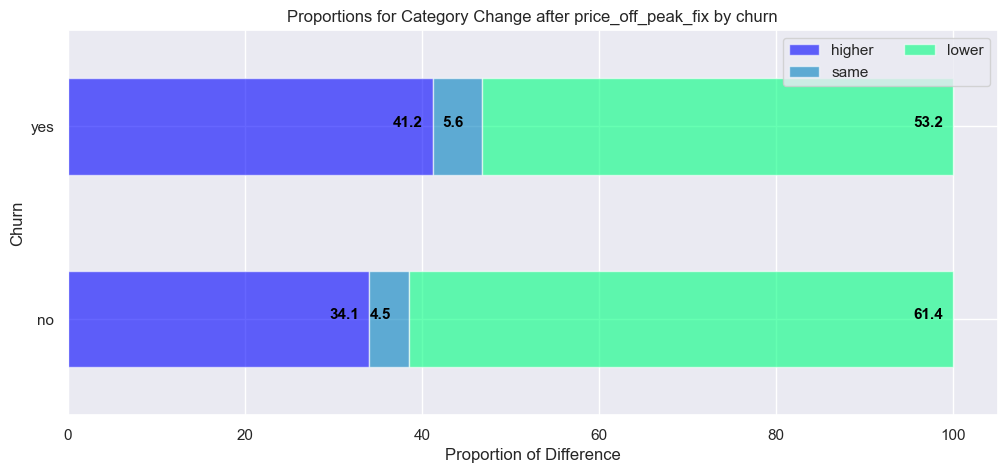

In [58]:
# Graph it
plot_diff_proportions(train, 'price_peak_fix', 'price_off_peak_fix', -4.5, 11)

The proportions of clients who changed price category from one period to the next does seem to effect churn. Clients who churned had about 7.1 percent more significant price increases than those those who did not churn. Those who churned had about 8.2 percent less price decreases. Those who stayed in the same price category still had a 1 percent more clients who churned.

Let's try the same for energy.

In [59]:
# Calculate the change in energy price category for clients from the 1st to 2nd period.
calc_diff_proportions(train, 'price_peak_var', 'price_off_peak_var').sort_values(by = 'churn', ascending = False)

,churn,higher,same,lower
1,yes,45.242370,3.231598,51.526032
0,no,36.556291,3.443709,60.000000


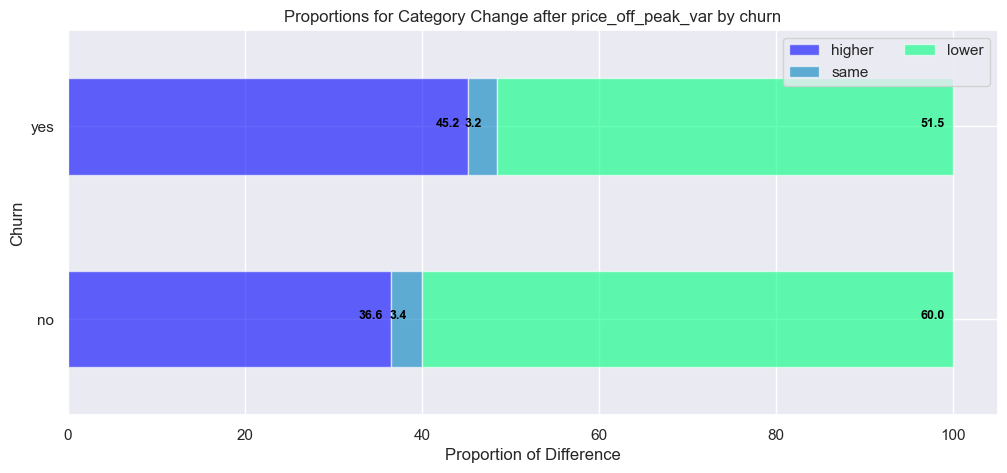

In [60]:
# Graph for energy
plot_diff_proportions(train, 'price_peak_var', 'price_off_peak_var', -3.7, 9)

We see a similar trend for energy prices, but the percent change is slightly larger. Clients who churned had over 8.6 percent more significant price increases compared to clients who did not churn. Clients who churned had over 8.4 percent less price decreases.

Let's check out the category changes for forecasted energy price from the 1st to 2nd period.

In [61]:
# Calculate change in forecasted energy price from the 1st to the 2nd period.
calc_diff_proportions(train, 'forecast_price_energy_peak', 'forecast_price_energy_off_peak').sort_values(by = 'churn', ascending = False)

,churn,higher,same,lower
1,yes,44.614004,2.603232,52.782765
0,no,36.300851,2.554399,61.144749


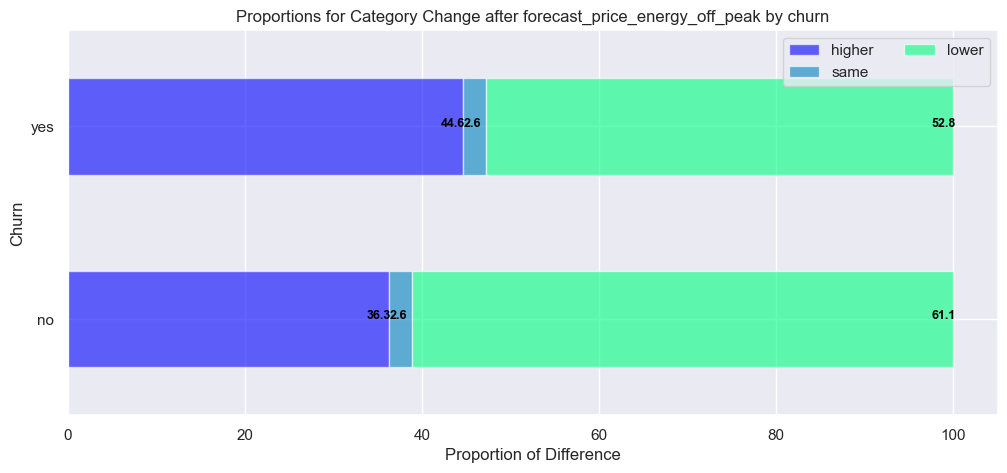

In [62]:
# Graph it
plot_diff_proportions(train, 'forecast_price_energy_peak', 'forecast_price_energy_off_peak', -2.5, 9)

Those who churned had 8.3 percent more increases in price_category, and 8.3 fewer price category decreases. The actual energy prices.

#### Number of Columns

At first, when we combined the price and client data, we had 49 columns. We have created new features each time the functions above were run to complete out analysis. We now have 95 columns, as seen below. 

In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11684 entries, 0 to 11683
Data columns (total 96 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   id                                   11684 non-null  object        
 1   channel_sales                        11684 non-null  object        
 2   cons_12m                             11684 non-null  int64         
 3   cons_gas_12m                         11684 non-null  int64         
 4   cons_last_month                      11684 non-null  int64         
 5   date_activ                           11684 non-null  datetime64[ns]
 6   date_end                             11684 non-null  datetime64[ns]
 7   date_modif_prod                      11684 non-null  datetime64[ns]
 8   date_renewal                         11684 non-null  datetime64[ns]
 9   forecast_cons_12m                    11684 non-null  float64       
 10  forecast_c

## Next Steps

In the next section, we'll use a random forest model to ascertain the best predictors of churn. Metrics that have the most influence on churn will be included in the model. That influence will be determined either by correlation or proportions of those who churned. Attributes that are moderately correlated with one another will not be included together in the model. 